In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import momlevel as ml

In [2]:
from dask.distributed import Client
from dask.distributed import LocalCluster
client = Client(dashboard_address=':8787')
client
#client.close()
#cluster.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 14
Total threads: 112,Total memory: 755.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41349,Workers: 14
Dashboard: http://127.0.0.1:8787/status,Total threads: 112
Started: Just now,Total memory: 755.56 GiB
Comm: tcp://127.0.0.1:39411,Total threads: 8
Dashboard: http://127.0.0.1:45313/status,Memory: 53.97 GiB
Nanny: tcp://127.0.0.1:44553,


In [16]:
# import SSS dataset and extract 'so' DataArray
salinity = xr.open_mfdataset('/home/pachamama/shared/model_output/sofia/cm4/so/annual/*.nc',
                            chunks={'time':1,'z_l':1},
                            drop_variables=['average_DT', 'average_T1', 'average_T2'],
                            )
salt = salinity.so
static = xr.open_dataset('/home/pachamama/shared/model_output/sofia/cm4/static/ocean_monthly_z.static.nc',chunks={'time':1,'z_l':1},drop_variables=['average_DT', 'average_T1', 'average_T2'],)

In [4]:

picont = xr.open_mfdataset('/home/pachamama/shared/model_output/cmip6/piControl/gfdl-cm4/so*.nc', chunks={'time':1,'z_l':1},
                            drop_variables=['average_DT', 'average_T1', 'average_T2'],
                            ).sel(time=slice('0251-01-16','0350-12-16'))


In [5]:
#picontrol_so = xr.open_mfdataset('/backup/tuq41374/model_output/cmip6/piControl/gfdl_cm4/ocean/monthly/so/*.nc',
                                #chunks={'time':1200,'x':180,'y':90}).sel(time=slice('0251-01-16','0350-12-16'))


CPU times: user 499 ms, sys: 105 ms, total: 604 ms
Wall time: 1.25 s


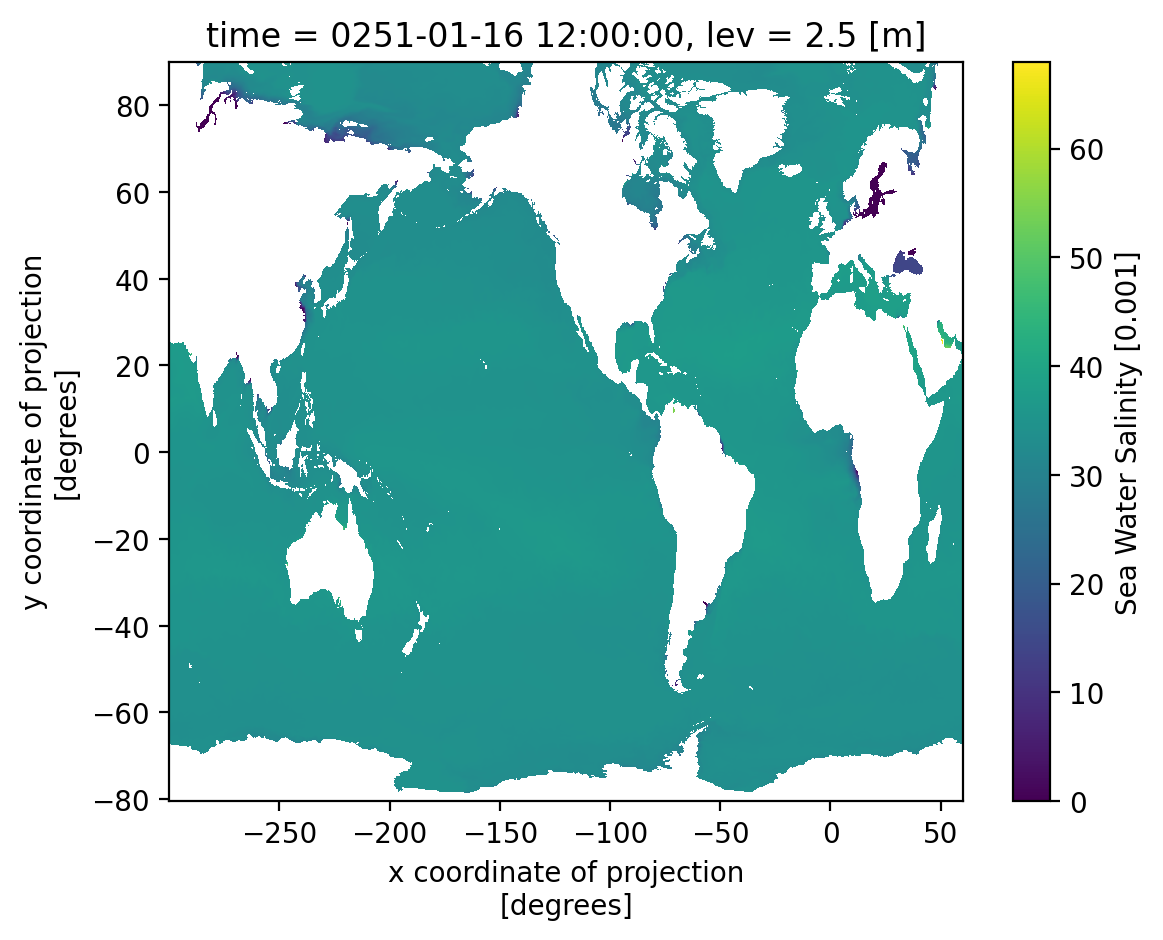

In [6]:
%%time
picont.so.isel(time=0, lev=0).plot()

In [7]:
%%time
saltPI251_350 = picont.so.isel(lev=0).mean(dim="time").load()

CPU times: user 10.1 s, sys: 1.4 s, total: 11.5 s
Wall time: 30.1 s


In [8]:
saltPI251_350 = saltPI251_350.rename({'x':'xh'}).rename({'y':'yh'})

CPU times: user 197 ms, sys: 28.1 ms, total: 225 ms
Wall time: 193 ms


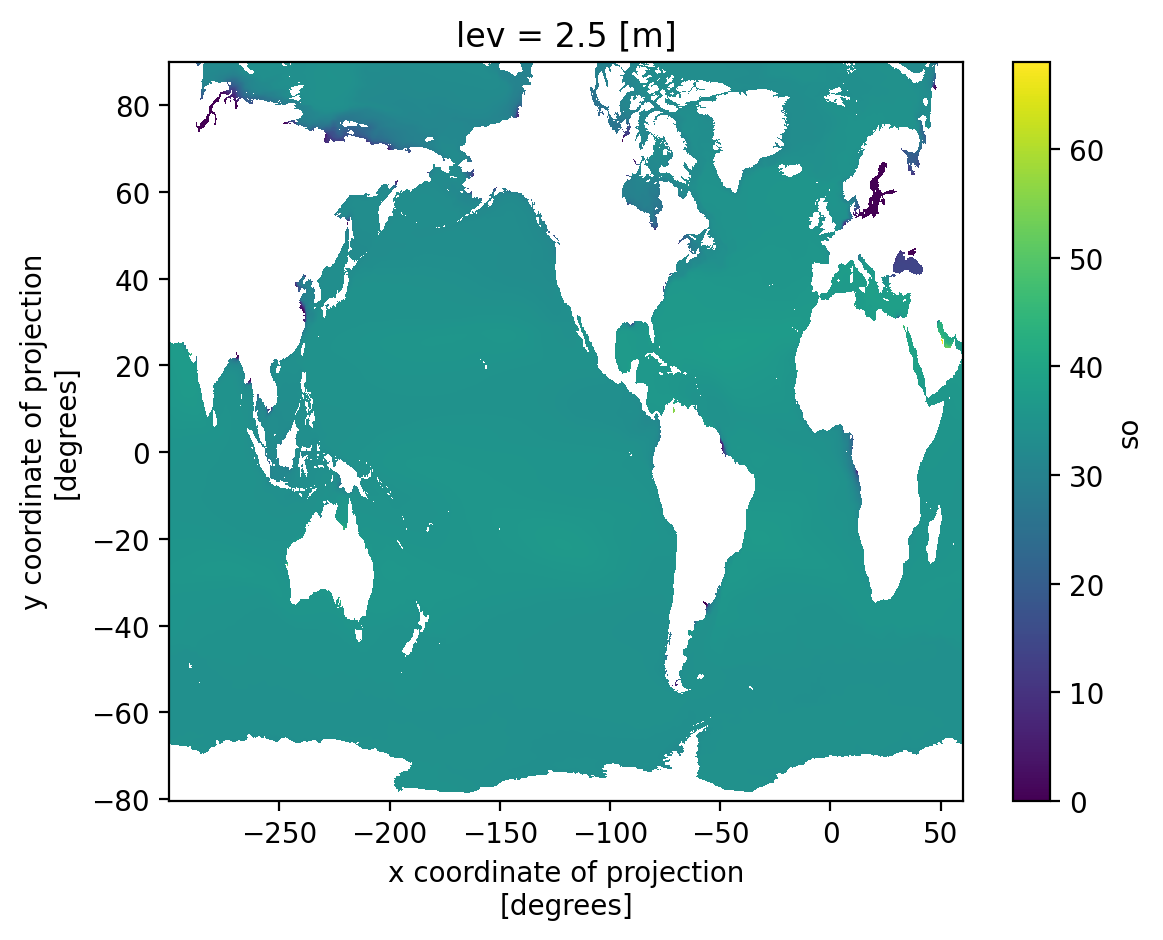

In [9]:
%%time 
saltPI251_350.plot()

In [10]:
saltPI251_350

<xarray.DataArray 'so' (yh: 1080, xh: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
    lev      float64 2.5
    lon      (yh, xh) float32 -299.7 -299.5 -299.2 -299.0 ... 60.0 60.0 60.0
    lat      (yh, xh) float32 -79.81 -79.81 -79.8 -79.8 ... 64.33 64.22 64.11

Text(0.5, 1.0, '100 Year Pre-Industrial Control Average')

<Figure size 1200x800 with 0 Axes>

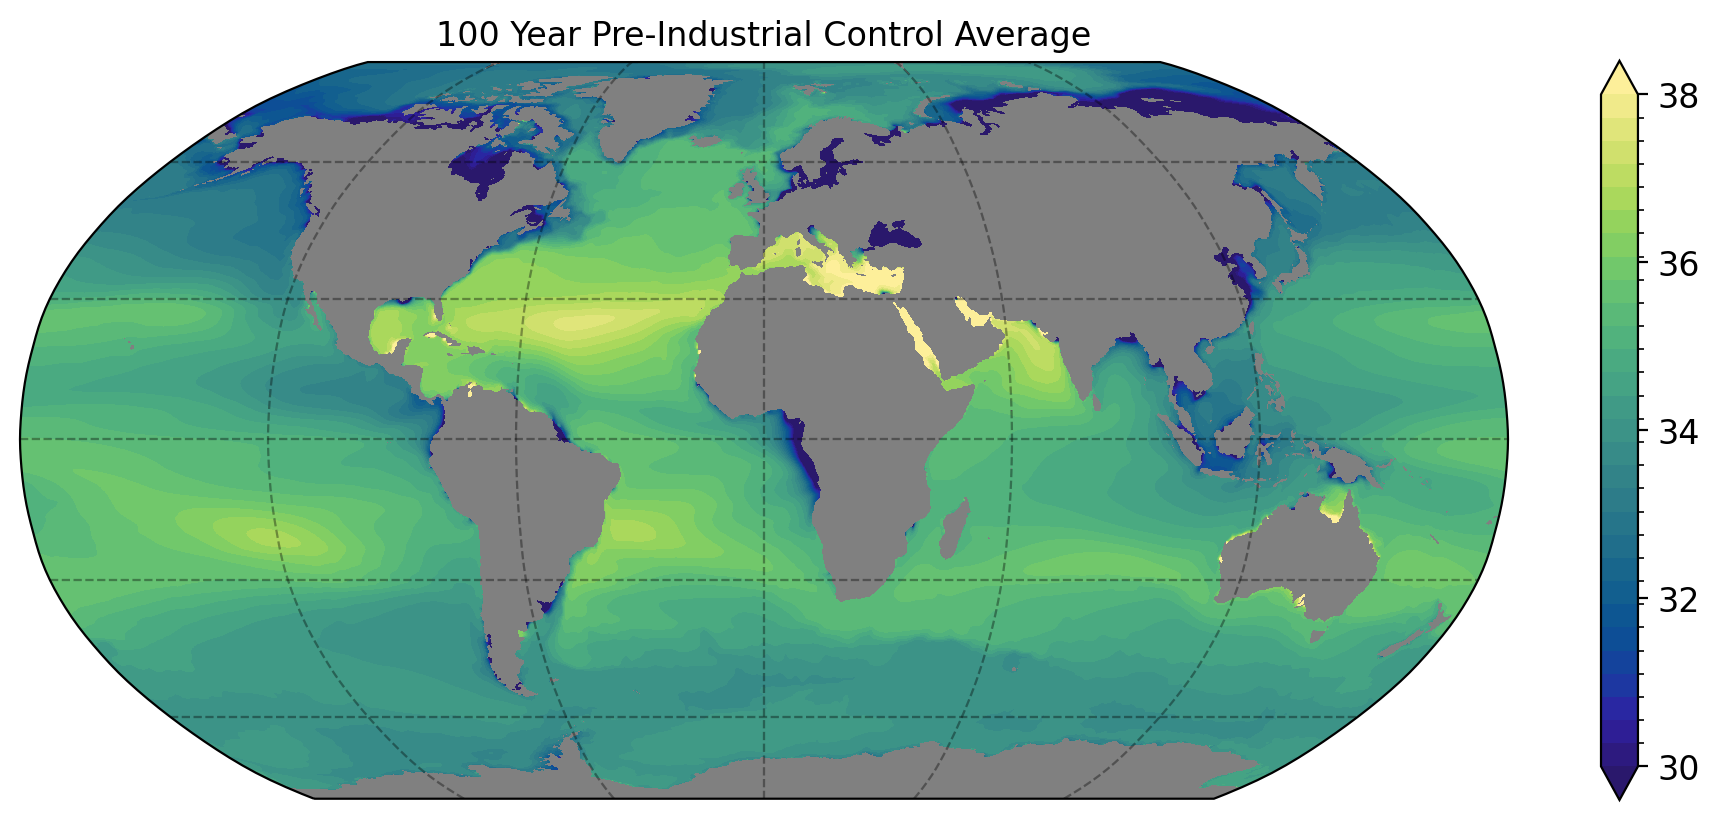

In [30]:
subplot_kws=dict(projection=ccrs.Robinson(),
                 )

plt.figure(figsize=[12,8])

subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='gray')

plt.figure(figsize=[12,8])
p = saltPI251_350.plot.contourf(x='lon', y='lat',
                        vmin=30,vmax=38,
                      cmap=cmocean.cm.haline,
                      subplot_kws=subplot_kws,
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False, levels= 30)

p.axes.gridlines(color='black', alpha=0.2, linestyle='--')
p.axes.gridlines(color='black', alpha=0.2, linestyle='--')

# add a seperate colorbar
cb = plt.colorbar(p, ticks=[30, 32, 34, 36, 38],shrink=0.6,extend='both')
cb.ax.tick_params(labelsize=12)
plt.title("100 Year Pre-Industrial Control Average")

Text(0.5, 1.0, '100 Year PIControl')

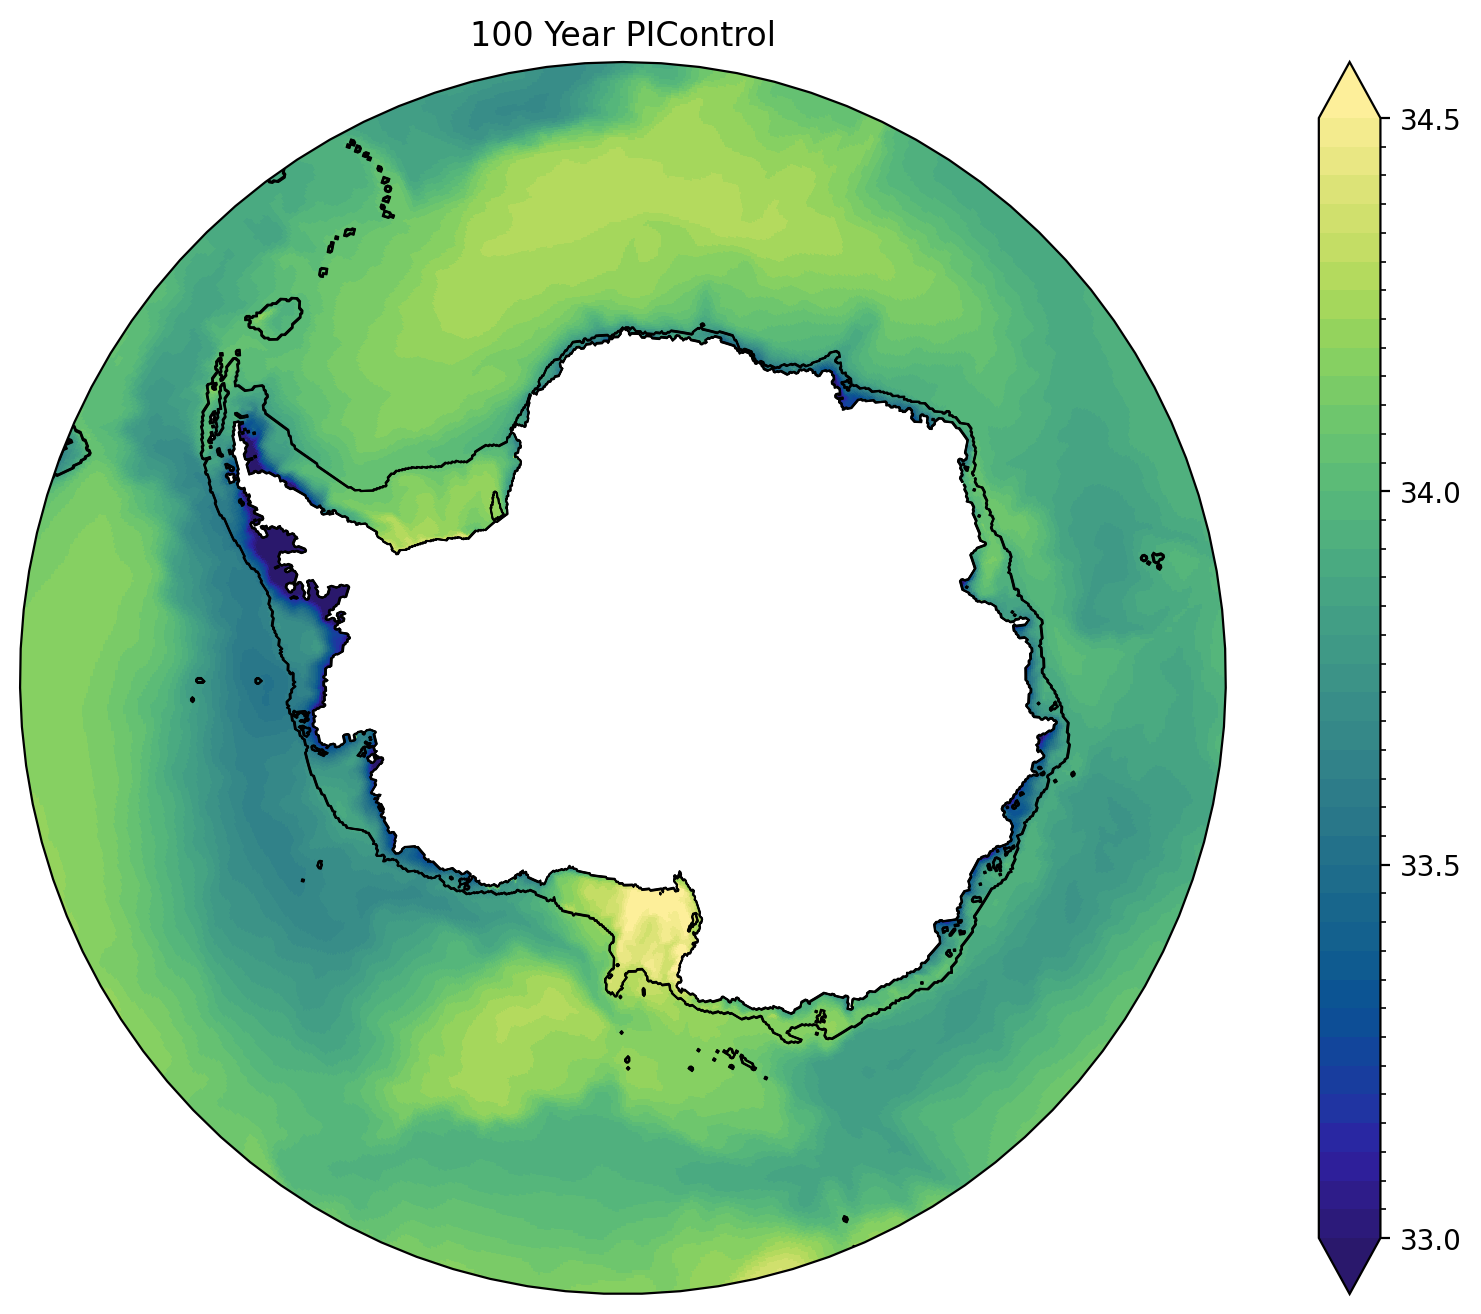

In [29]:
depth = static["deptho"]
depth

shelf = depth.where(depth<1000)*0
shelfmask = shelf.isin(0)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)
ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

p = saltPI251_350.plot(x='xh', y='yh',
                        vmin=33,vmax=34.5,
                        cmap=cmocean.cm.haline,
                        transform=ccrs.PlateCarree(),add_colorbar=False, levels= 40)
shelfmask.plot.contour(x='xh', y='yh',transform=ccrs.PlateCarree(),colors='black', linewidths = .5)
cb = plt.colorbar(p, ticks=[33, 33.5, 34, 34.5],extend='both')
plt.title("100 Year PIControl")

Text(0, 0.5, 'Latitude')

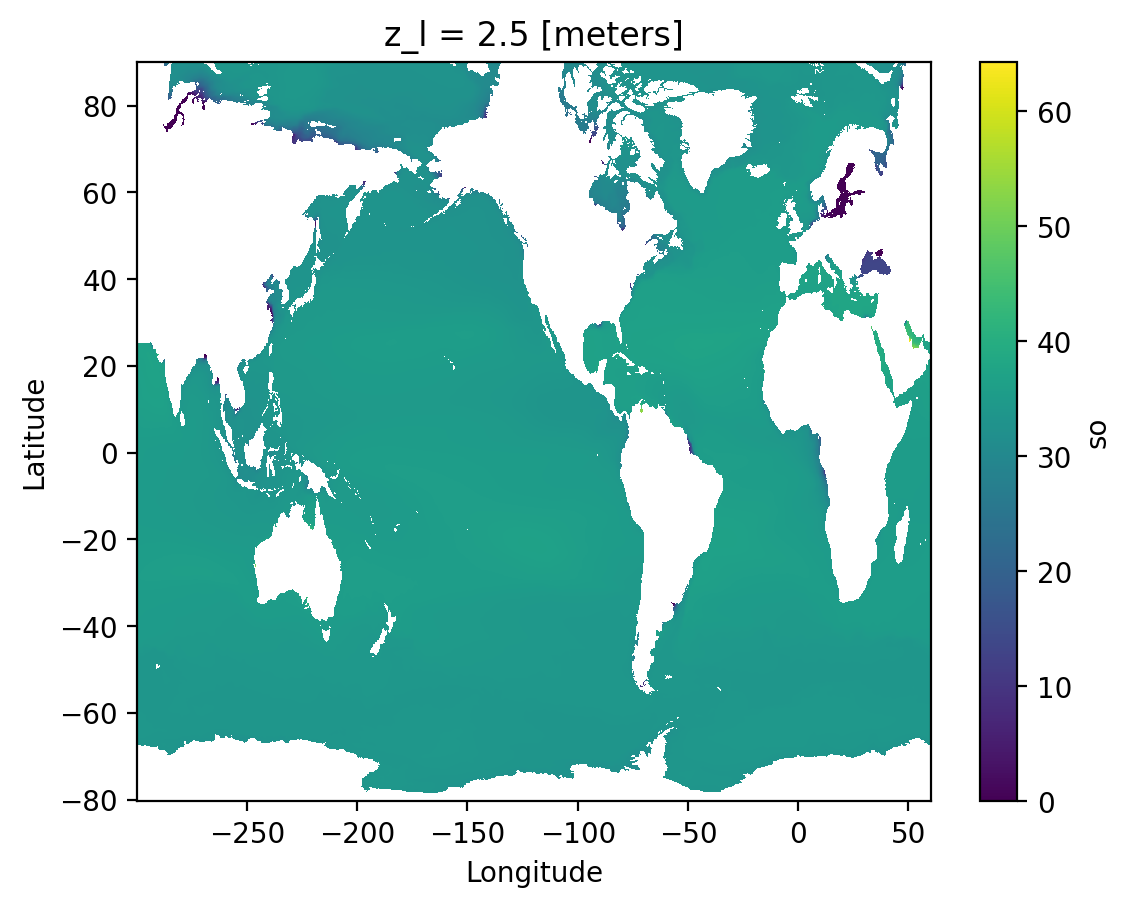

In [27]:
lasttwenty = salt.isel(time=slice(80,100)).isel(z_l=0).mean(dim="time")
lasttwenty.plot()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

CPU times: user 930 ms, sys: 56.2 ms, total: 986 ms
Wall time: 1.16 s


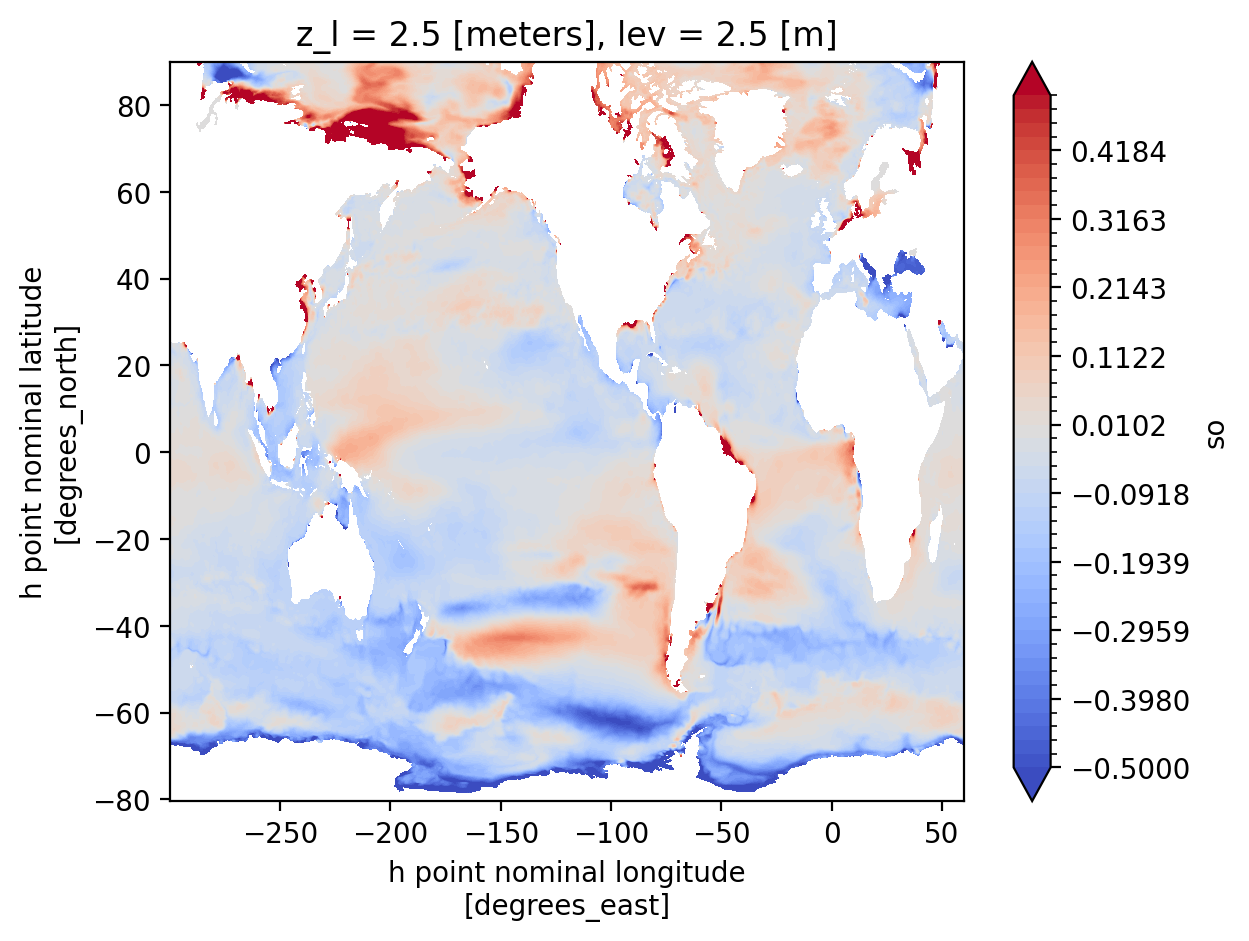

In [17]:
%%time
diff = lasttwenty - saltPI251_350
diff.plot.contourf(vmin=-.5, vmax=.5, levels=50, cmap='coolwarm' )

In [18]:
static = xr.open_dataset('/home/pachamama/shared/model_output/sofia/cm4/static/ocean_monthly_z.static.nc')

In [45]:
lasttwenty['geolon'] = static.geolon
lasttwenty['geolat'] = static.geolat
saltPI251_350['geolat'] = static.geolat
saltPI251_350['geolon'] = static.geolon
diff['geolon'] = static.geolon
diff['geolat'] = static.geolat

Text(0.5, 1.0, '100yr PI to Last Twenty yr Difference')

<Figure size 1200x800 with 0 Axes>

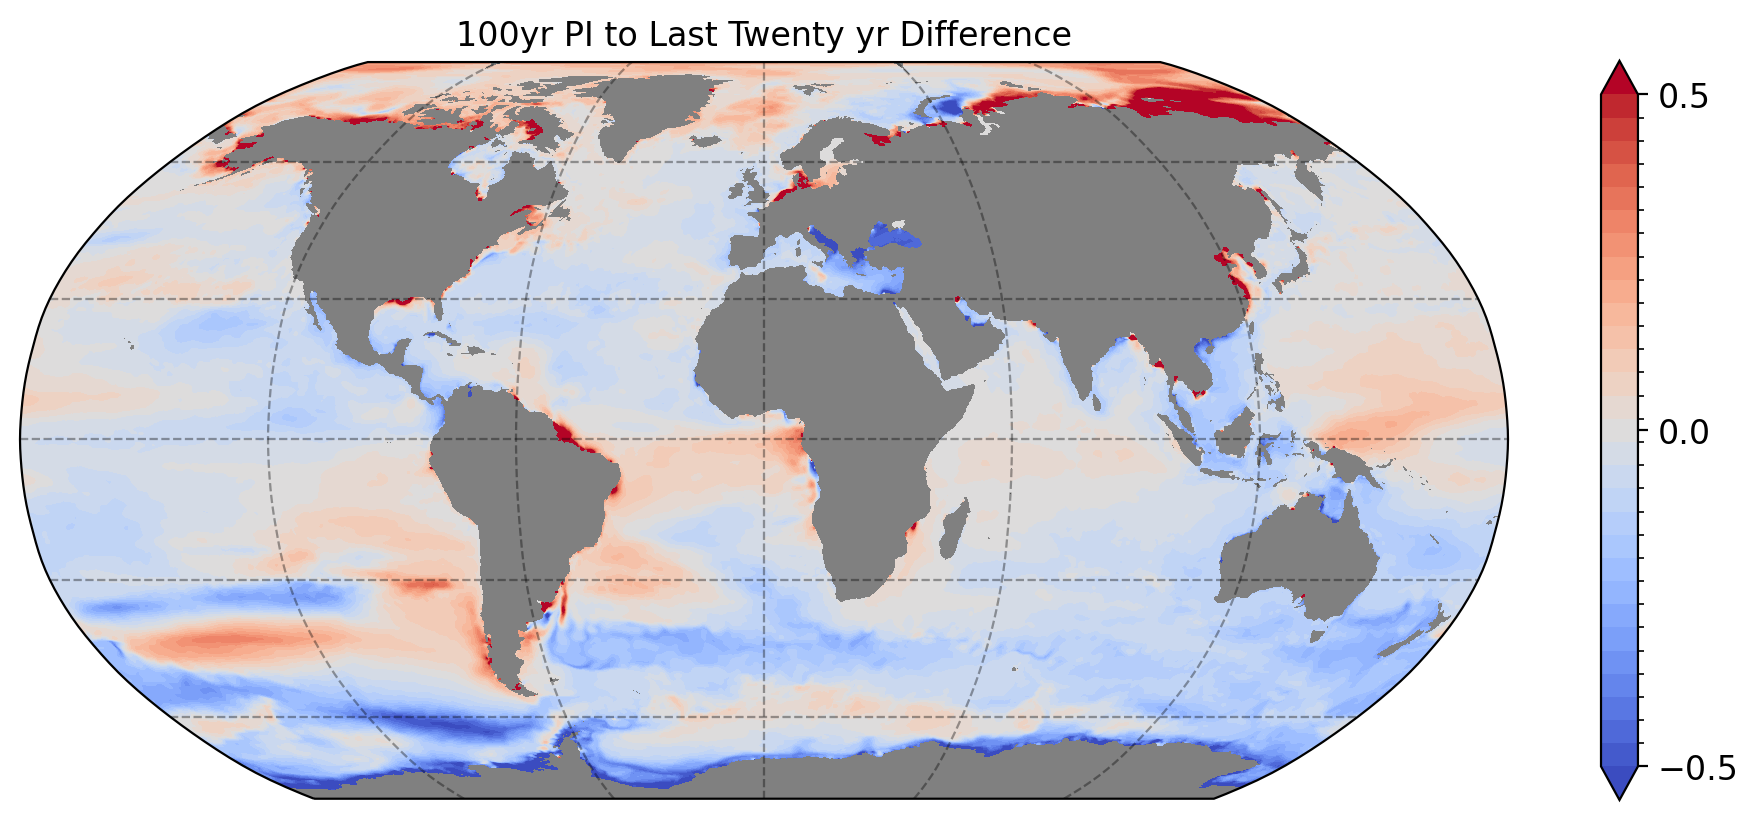

In [46]:
subplot_kws=dict(projection=ccrs.Robinson(),
                 )

plt.figure(figsize=[12,8])

subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='gray')

plt.figure(figsize=[12,8])
p = diff.plot.contourf(x='geolon', y='geolat',
                        vmin=-.5,vmax=.5,
                      cmap='coolwarm',
                      subplot_kws=subplot_kws,
                      transform=ccrs.PlateCarree(),
                      add_colorbar=False, levels= 30)

p.axes.gridlines(color='black', alpha=0.2, linestyle='--')
p.axes.gridlines(color='black', alpha=0.2, linestyle='--')

# add a seperate colorbar
cb = plt.colorbar(p, ticks=[-0.5,0,0.5],shrink=0.6,extend='both')
cb.ax.tick_params(labelsize=12)
plt.title("100yr PI to Last Twenty yr Difference")

In [3]:
depth = static["deptho"]
depth

shelf = depth.where(depth<1000)*0
shelfmask = shelf.isin(0)

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=[12,8])

projection=ccrs.SouthPolarStereo()
ax = plt.axes(projection=projection)
ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree())
ax.set_boundary(circle,transform=ax.transAxes)

p = diff.plot(x='xh', y='yh',
                        vmin=-.5,vmax=.5,
                        cmap='coolwarm',
                        transform=ccrs.PlateCarree(),add_colorbar=False, levels= 40)
shelfmask.plot.contour(x='xh', y='yh',transform=ccrs.PlateCarree(),colors='black', linewidths = .5)
cb = plt.colorbar(p, ticks=[-.5, 0, .5],extend='both')

NameError: name 'static' is not defined